In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import time
import pandas as pd
import numpy as np
import joblib

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from dask_ml.wrappers import ParallelPostFit

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [2]:
%%time
df = pd.read_csv('../data/new_balanced_data_250_preprocessed.csv')
df.tail()

Wall time: 398 ms


,short_descriptions,assignment_groups
272995,not orion,Service Desk - Sales All
272996,NaN,Service Desk - Sales All
272997,pac to tool unable,Service Desk - Sales All
272998,hcp wrong,Service Desk - Sales All
272999,able not successfully to user,Service Desk - Sales All


In [3]:
vectorizer = joblib.load('../models/vectorizer')
encoder = joblib.load('../models/encoder')

In [4]:
df.isna().sum() / len(df) * 100

short_descriptions    3.575092
assignment_groups     0.000000
dtype: float64

In [5]:
df.fillna('', inplace=True)

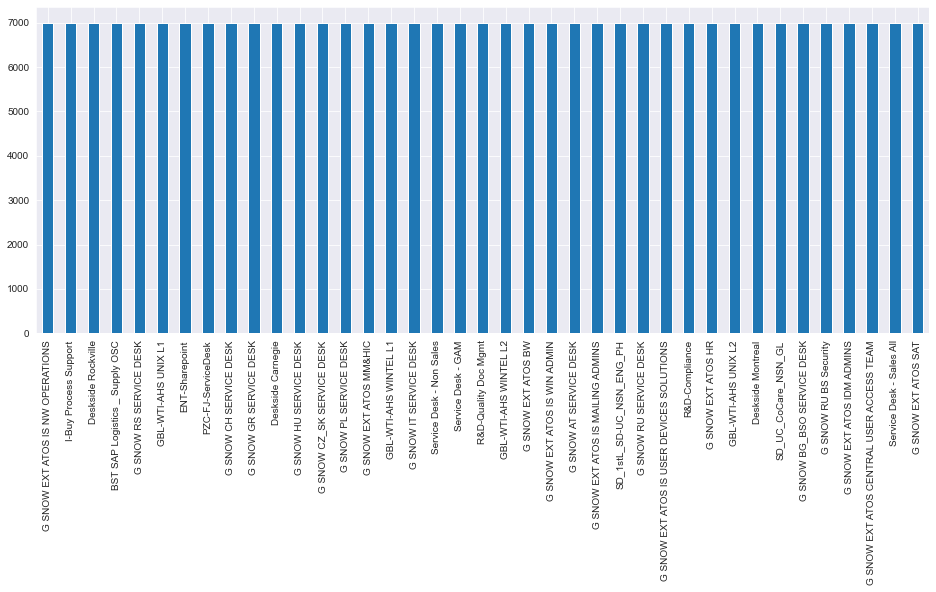

In [6]:
df['assignment_groups'].value_counts().plot(kind='bar', figsize=(16, 6))
plt.show()

In [7]:
X = df['short_descriptions'].values
y = df['assignment_groups'].values

In [8]:
X

array(['track table to change some pallet status in the warehouse 046',
       'to modify user ro912826 contentcreator',
       'permission deny on server gsunk910f', ..., 'pac to tool unable',
       'hcp wrong', 'able not successfully to user'], dtype=object)

In [9]:
y

array(['G SNOW IT SERVICE DESK',
       'G SNOW EXT ATOS CENTRAL USER ACCESS TEAM', 'GBL-WTI-AHS UNIX L1',
       ..., 'Service Desk - Sales All', 'Service Desk - Sales All',
       'Service Desk - Sales All'], dtype=object)

In [10]:
%%time
X = vectorizer.transform(X)

Wall time: 2.01 s


In [11]:
%%time
y = encoder.transform(y.astype(str))

Wall time: 369 ms


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [13]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(245700, 31014) (245700,) (27300, 31014) (27300,)


In [14]:
models = [
    MultinomialNB(),
    LogisticRegression(n_jobs=-1),
#     RandomForestClassifier(n_jobs=-1),
#     LinearSVC(),
#     XGBClassifier(n_jobs=-1),
    DecisionTreeClassifier()
]


def display_metrics(true, pred):
    f1 = round(f1_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    precision = round(precision_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    recall = round(recall_score(y_true=true, y_pred=pred, average='weighted') * 100, 2)
    acc = round(accuracy_score(y_true=y_test, y_pred=preds) * 100, 2)

    print(f'Acc: {acc}')
    print(f'F1: {f1}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')

In [15]:
%%time

trained_models = dict()

for model in models:
    print(f'Training -> {model.__class__.__name__}')
    s = time.time()
    
    trained_models[model.__class__.__name__] = ParallelPostFit(
       estimator=model
    )
    
    trained_models[model.__class__.__name__].fit(X_train, y_train)
    
    e = time.time()
    
    preds = trained_models[model.__class__.__name__].predict(X_test)
    display_metrics(true=y_test, pred=preds)
    
    print(f'Training time: {round(e - s)} seconds')
    print('-' * 10)

Training -> MultinomialNB
Acc: 67.57
F1: 67.62
Precision: 70.06
Recall: 67.57
Training time: 0 seconds
----------
Training -> LogisticRegression
Acc: 72.29
F1: 72.78
Precision: 74.4
Recall: 72.29
Training time: 96 seconds
----------
Training -> DecisionTreeClassifier
Acc: 74.22
F1: 74.48
Precision: 76.4
Recall: 74.22
Training time: 51 seconds
----------
Wall time: 2min 27s


In [23]:
import joblib

In [24]:
joblib.dump(trained_models['RandomForestClassifier'], '../models/randomforest.joblib', compress=2)

['../models/randomforest.joblib']

In [35]:
test = np.array([
    'HCP restriction removal'
])
test = vectorizer.transform(test)

In [36]:
prediction = trained_models['RandomForestClassifier'].predict(test)

In [38]:
encoder.inverse_transform(prediction)[0]

'Service Desk - Sales All'